In [42]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes

# 用于绘图的风格
sns.set(style="whitegrid")

In [43]:
# 加载数据
import pandas as pd
df = pd.read_excel('D:\\绿地降温可达性论文数据处理\\各种表格存放\\实验xgboost第三次剔除一些因子.xlsx')
df.head()

,xuhao,PCM,Park_area,Park_perimeter,Park_LSI,Buffer_PR,Buffer_BD,Buffer_MBH,Buffer_SVF,Buffer_FAI,...,Park_slope,Buffer_tree,Buffer_grass,Buffer_water,Buffer_builtup,Park_tree,Park_grass,Park_water,Park_builtup,Park_Canopy height
0,2,2.139181,134.088418,5.700355,1.388677,0.654605,0.103236,12.808735,0.768803,0.087648,...,3.590501,0.251513,0.045288,0.064310,0.382062,0.190984,0.108068,0.364505,0.177554,3.792805
1,4,0.784743,6.821604,1.082591,1.169274,0.155824,0.075225,5.644737,0.863299,0.023628,...,3.146070,0.104345,0.004937,0.001810,0.867688,0.429825,0.083333,0.114035,0.288210,4.582345
2,5,4.330727,30.312817,2.315124,1.186195,0.057109,0.028497,4.950000,0.952954,0.007958,...,3.262611,0.079370,0.225632,0.022400,0.304112,0.233026,0.083388,0.594265,0.036939,3.973614
3,6,2.203708,3.788025,0.789883,1.144858,0.051192,0.028674,4.322034,0.937739,0.011046,...,2.863481,0.083952,0.002733,0.016009,0.827768,0.367021,0.039894,0.000000,0.579787,3.123223
4,7,3.815329,87.817038,3.977914,1.197460,0.032947,0.020813,4.330189,0.967952,0.005726,...,2.662037,0.384110,0.019863,0.122229,0.366990,0.623562,0.001253,0.192093,0.037579,10.084170


In [44]:
from sklearn.model_selection import train_test_split

# 首先将数据集划分为训练集和测试集
X_temp, X_test, y_temp, y_test = train_test_split(df.iloc[:,2:29], df['PCM'], test_size=0.2, random_state=2024)

# 然后将训练集进一步划分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=2024)  # 0.125 x 0.8 = 0.1

# 输出数据集的大小
print(f"训练集维度: {X_train.shape}")
print(f"验证集维度: {X_val.shape}")
print(f"测试集维度: {X_test.shape}")

训练集维度: (890, 22)
验证集维度: (128, 22)
测试集维度: (255, 22)


In [45]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(y_train, y_val, y_test):
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_train).reshape(-1, 1))  # 在训练集上拟合归一化模型 MinMaxScaler输入数据形状为二维数组
    
    train = pd.DataFrame(scaler.transform(np.array(y_train).reshape(-1, 1)), index=y_train.index)
    val = pd.DataFrame(scaler.transform(np.array(y_val).reshape(-1, 1)), index=y_val.index)
    test = pd.DataFrame(scaler.transform(np.array(y_test).reshape(-1, 1)), index=y_test.index)
    
    return train, val, test, scaler

train_y, val_y, test_y, scaler_y = normalize_dataframe(y_train, y_val, y_test)

In [46]:
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.05],
    'n_estimators': [200],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'gamma': [0.2]
}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


In [47]:
best_params = grid_search.best_params_

model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)



In [48]:
from sklearn import metrics
y_pred_list = y_pred.tolist()  # 或者 y_pred_array = np.array(y_pred)
mse = metrics.mean_squared_error(y_test, y_pred_list)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred_list)
r2 = metrics.r2_score(y_test, y_pred_list)

print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("平均绝对误差 (MAE):", mae)
print("拟合优度 (R-squared):", r2)

均方误差 (MSE): 1.2068757890683504
均方根误差 (RMSE): 1.0985789862674191
平均绝对误差 (MAE): 0.8629164459066129
拟合优度 (R-squared): 0.5495970455324632


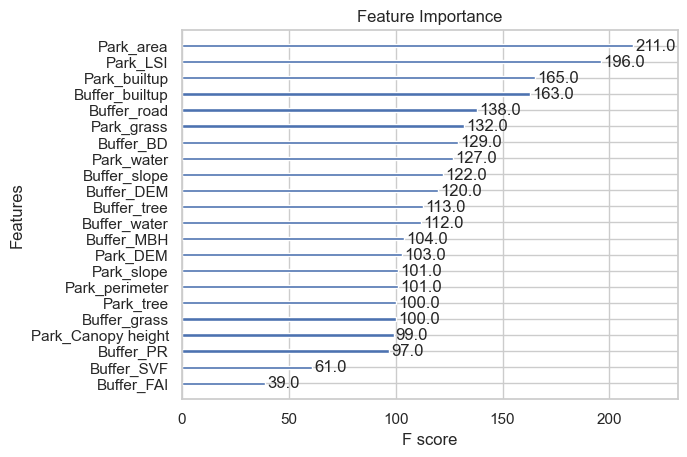

In [49]:
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

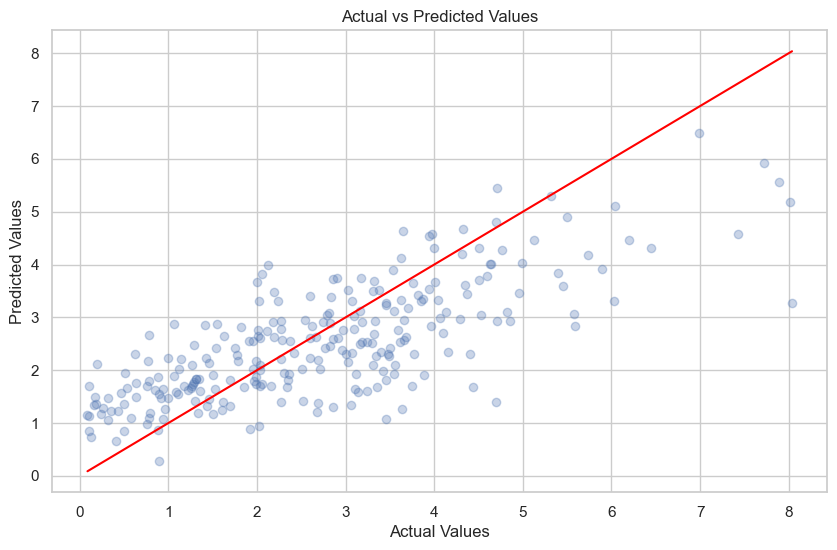

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

[21:58:17] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


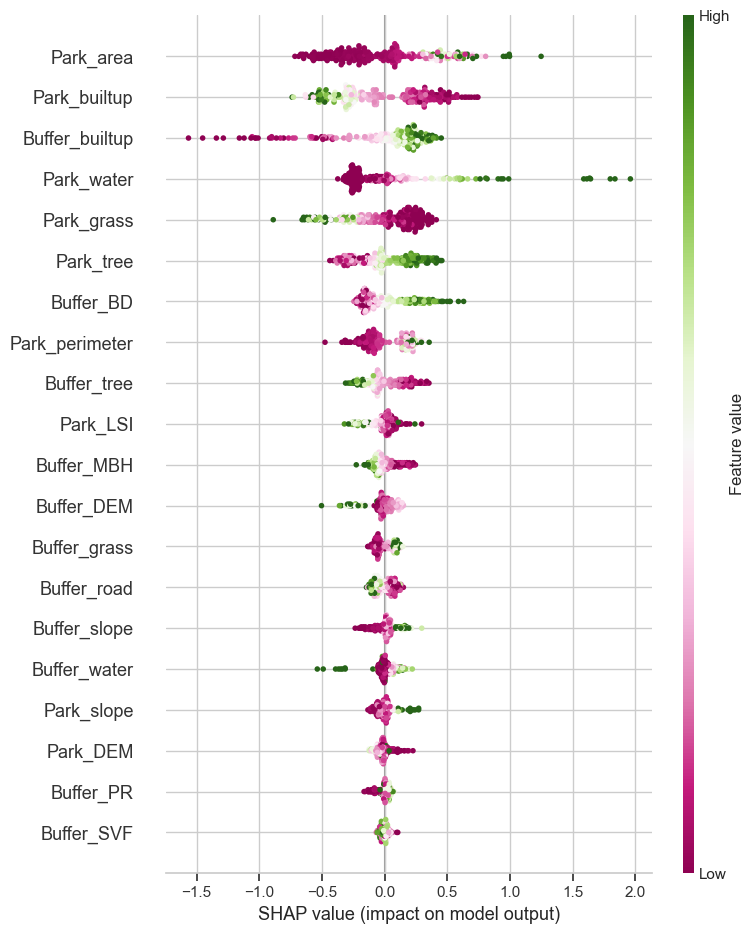

In [51]:
import shap
import time
# 创建 SHAP 解释器
explainer = shap.TreeExplainer(model)

# 解释模型的预测结果
shap_values = explainer.shap_values(X_test)

# 可视化 SHAP 解释
plt.figure()
shap.summary_plot(shap_values, X_test, cmap='PiYG',show=False)
plt.savefig("C:/Users/26065/Desktop/ss/shap.eps", bbox_inches='tight', format='eps')
plt.close()
# 显示图像
# 可视化 SHAP 解释
plt.figure()
shap.summary_plot(shap_values, X_test, cmap='PiYG')
plt.show()
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


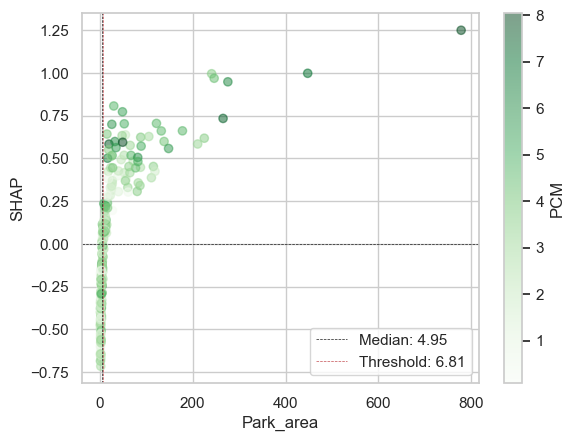

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


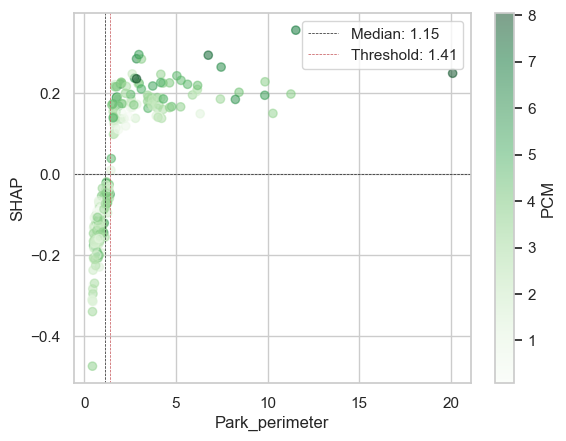

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


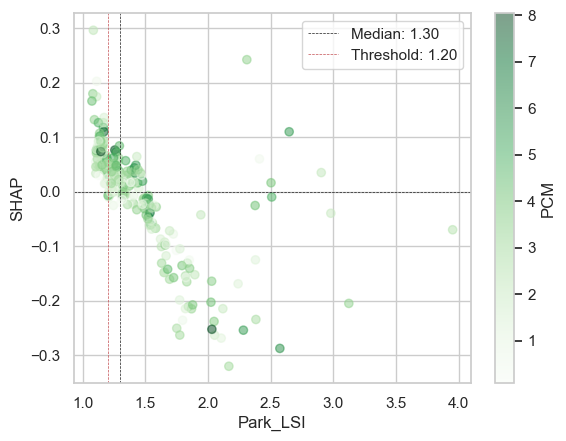

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


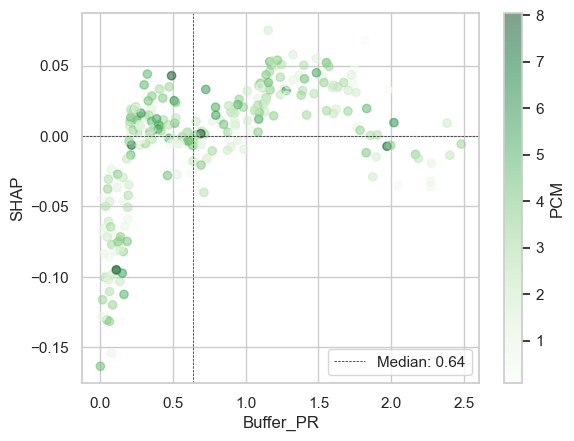

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


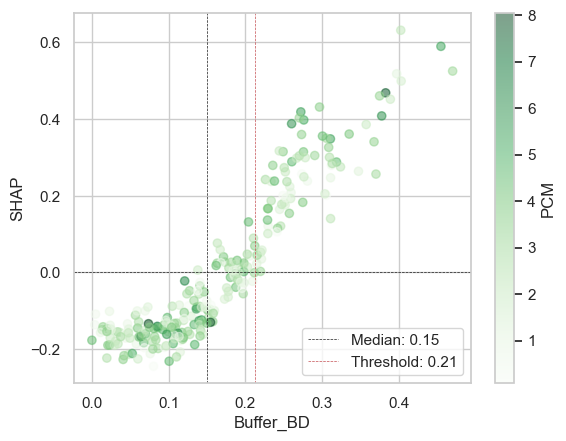

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


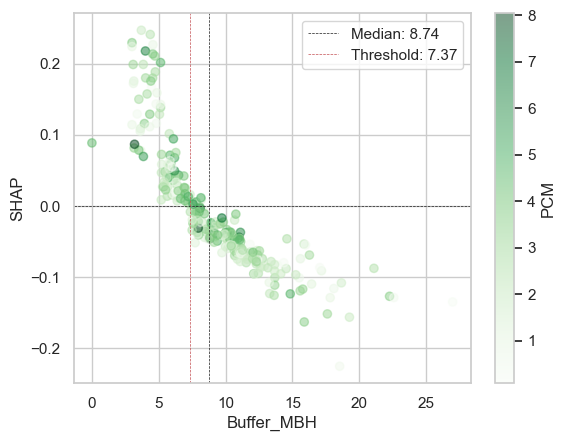

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


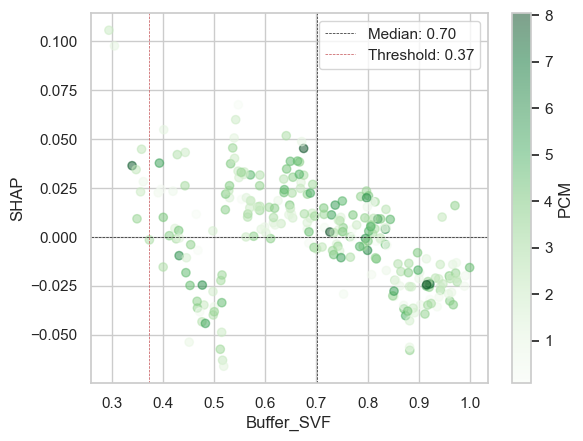

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


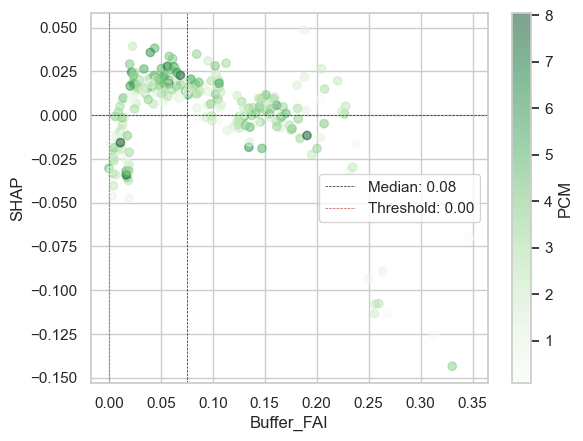

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


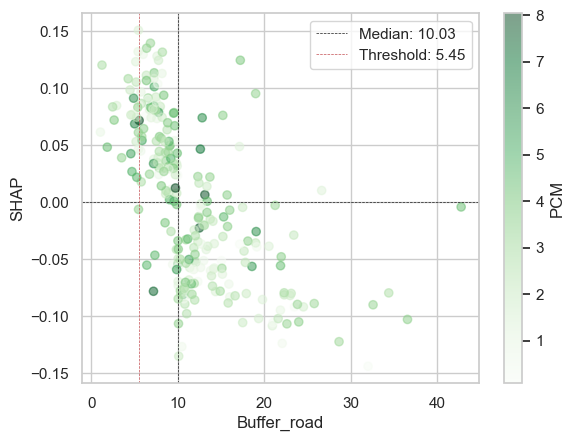

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


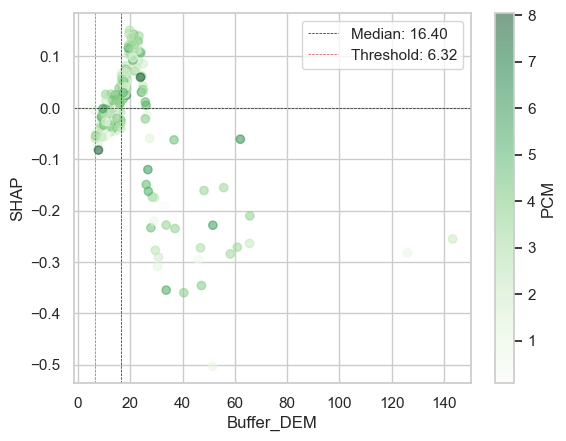

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


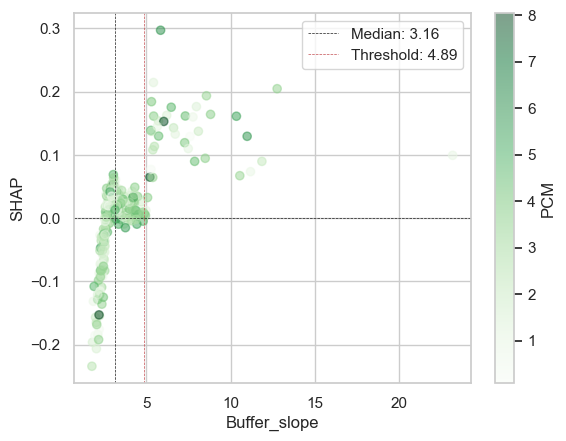

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


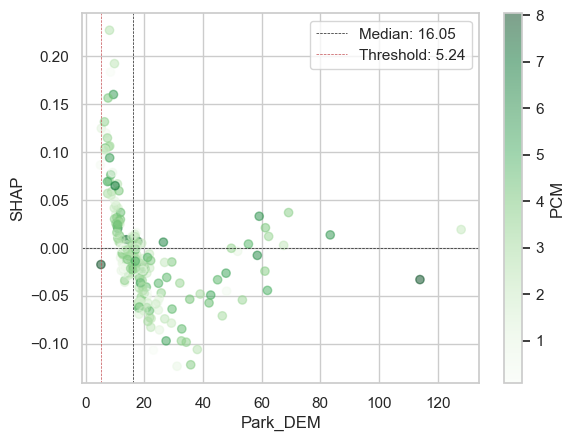

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


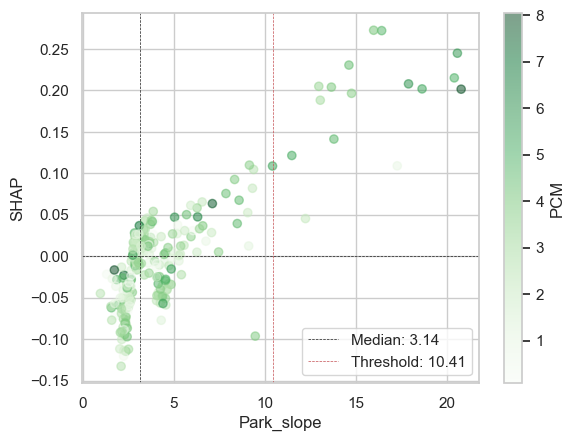

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


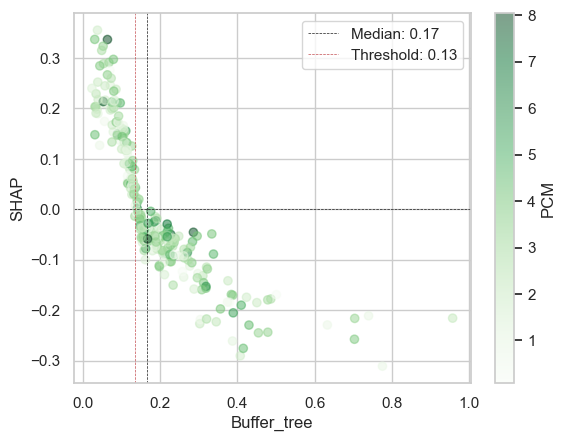

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


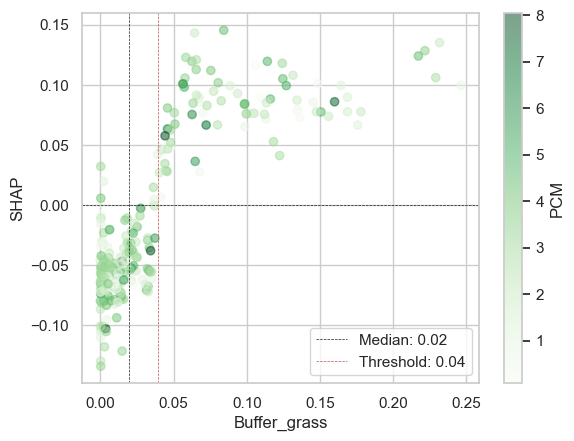

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


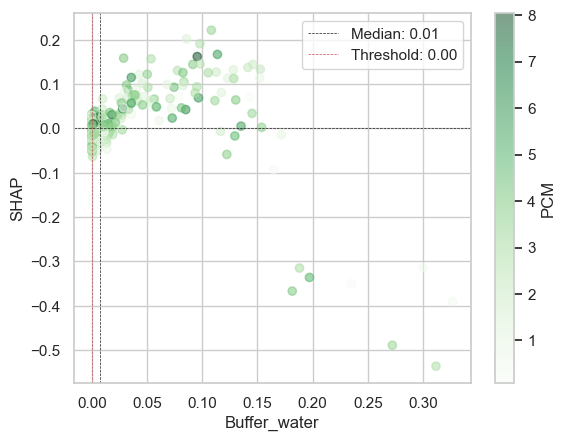

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


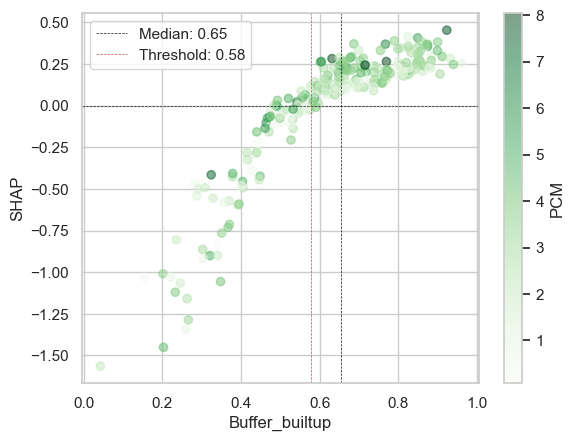

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


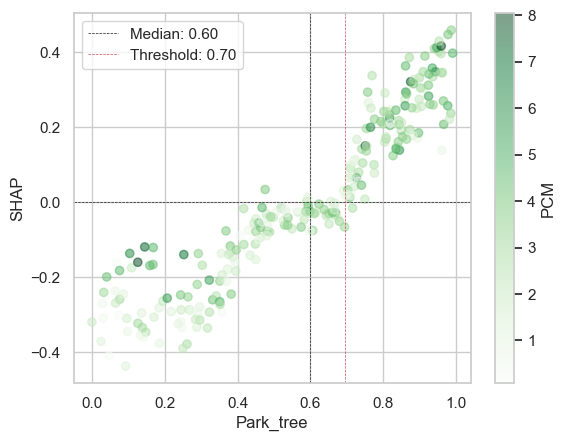

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


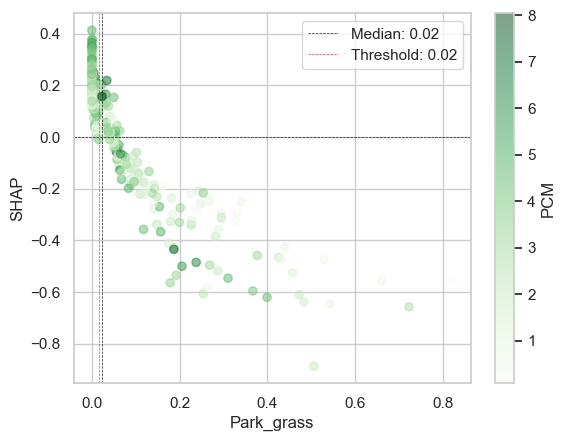

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


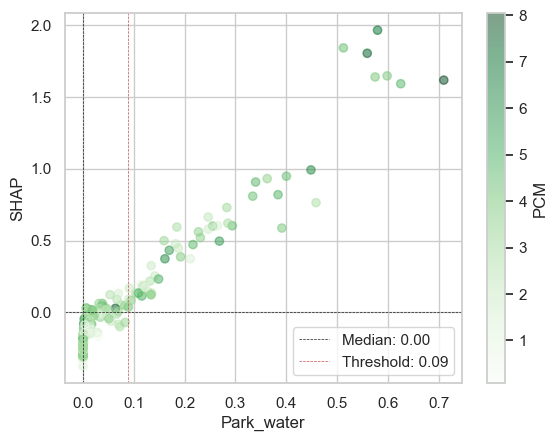

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


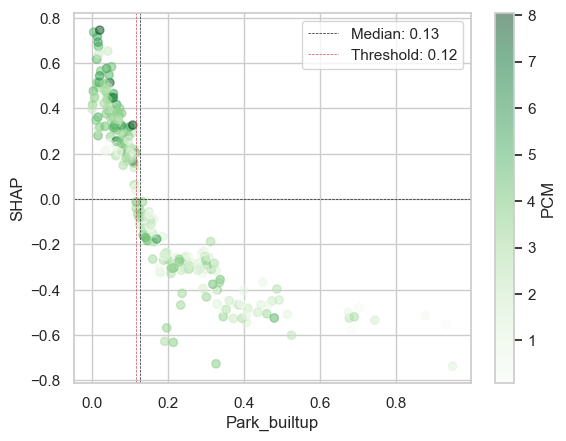

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


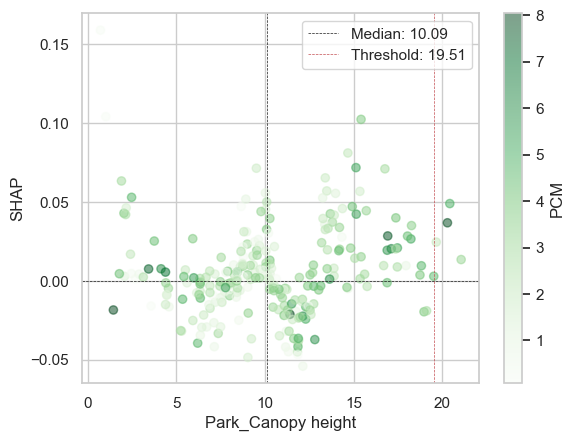

特征: Park_area, Median: 4.95, Threshold: 6.81
特征: Park_perimeter, Median: 1.15, Threshold: 1.41
特征: Park_LSI, Median: 1.30, Threshold: 1.20
特征: Buffer_PR, Median: 0.64, Threshold: nan
特征: Buffer_BD, Median: 0.15, Threshold: 0.21
特征: Buffer_MBH, Median: 8.74, Threshold: 7.37
特征: Buffer_SVF, Median: 0.70, Threshold: 0.37
特征: Buffer_FAI, Median: 0.08, Threshold: 0.00
特征: Buffer_road, Median: 10.03, Threshold: 5.45
特征: Buffer_DEM, Median: 16.40, Threshold: 6.32
特征: Buffer_slope, Median: 3.16, Threshold: 4.89
特征: Park_DEM, Median: 16.05, Threshold: 5.24
特征: Park_slope, Median: 3.14, Threshold: 10.41
特征: Buffer_tree, Median: 0.17, Threshold: 0.13
特征: Buffer_grass, Median: 0.02, Threshold: 0.04
特征: Buffer_water, Median: 0.01, Threshold: 0.00
特征: Buffer_builtup, Median: 0.65, Threshold: 0.58
特征: Park_tree, Median: 0.60, Threshold: 0.70
特征: Park_grass, Median: 0.02, Threshold: 0.02
特征: Park_water, Median: 0.00, Threshold: 0.09
特征: Park_builtup, Median: 0.13, Threshold: 0.12
特征: Park_Canopy heigh

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设 X_test, shap_values 和 y_test 已经定义并准备好
# X_test 是测试集特征数据框
# shap_values 是 SHAP 值数组
# y_test 是测试集目标变量数组

# 获取特征名称
feature_names = X_test.columns

# 计算阈值和中位数
thresholds_and_medians = []

for feature in feature_names:
    plt.figure()
    feature_index = X_test.columns.get_loc(feature)  # 获取特征在数据框中的索引
    feature_values = X_test[feature]
    shap_values_feature = shap_values[:, feature_index]

    # 排序特征值和对应的 SHAP 值
    sorted_indices = np.argsort(feature_values)
    sorted_feature_values = feature_values.iloc[sorted_indices]
    sorted_shap_values = shap_values_feature[sorted_indices]

    num_points = len(sorted_feature_values)

    # 判断趋势并计算阈值
    correlation = np.corrcoef(sorted_feature_values, sorted_shap_values)[0, 1]
    if correlation >= 0:
        # 递增趋势
        for i in range(num_points):
            if np.sum(sorted_shap_values[i:] > 0) >= 0.99 * (num_points - i):
                threshold_value = sorted_feature_values.iloc[i]
                break
        else:
            threshold_value = np.nan
    else:
        # 递减趋势
        for i in range(num_points - 1, -1, -1):
            if np.sum(sorted_shap_values[:i] > 0) >= 0.99 * i:
                threshold_value = sorted_feature_values.iloc[i]
                break
        else:
            threshold_value = np.nan

    # 计算特征的中位数
    median_value = np.median(feature_values)

    # 保存阈值和中位数
    thresholds_and_medians.append((feature, median_value, threshold_value))

    # 绘制散点图
    plt.scatter(feature_values, shap_values_feature, c=y_test, cmap='Greens', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(median_value, color='k', linestyle='--', linewidth=0.5, label=f'Median: {median_value:.2f}')
    if not np.isnan(threshold_value):
        plt.axvline(threshold_value, color='r', linestyle='--', linewidth=0.5, label=f'Threshold: {threshold_value:.2f}')
    plt.xlabel(feature)
    plt.ylabel('SHAP')
    plt.colorbar(label='PCM')
    plt.legend()

    # 保存图像
    plt.savefig(f"C:/Users/26065/Desktop/ss/_{feature}.eps", bbox_inches='tight', format='eps')
    
    # 显示图像
    plt.show()

# 输出每个特征对应的中位数和阈值
for feature, median_value, threshold_value in thresholds_and_medians:
    print(f"特征: {feature}, Median: {median_value:.2f}, Threshold: {threshold_value:.2f}")
